In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import pandas as pd

File = '/content/drive/MyDrive/Algoritmos/Datathon/Datos/IdentificacionSesgo - DataSet29.06.csv'
df = pd.read_csv(File, header = 0)

In [3]:
df['GravedadMode'] = df['Gravedad'].str.split(',',expand=True).mode(axis=1, numeric_only=False, dropna=True)[0]


In [4]:
df = df[['Item (Texto)', 'GravedadMode']]


In [5]:
x = df['Item (Texto)'].values
y = df['GravedadMode'].values

In [6]:
from tensorflow import keras
%tensorflow_version 2.x

In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence

In [8]:
t = Tokenizer()
t.fit_on_texts(x)

In [9]:
vocab_size = len(t.word_index) + 1
print(vocab_size)

3209


In [10]:
sequences = t.texts_to_sequences(x)

In [11]:
import numpy as np

np.shape(sequences)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(146,)

In [12]:
def max_news():
    for i in range(1, len(sequences)):
        max_length = len(sequences[0])
        if len(sequences[i]) > max_length:
            max_length = len(sequences[i])
    return max_length

In [13]:
news_num = max_news()
news_num

76

In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded_x = pad_sequences(sequences, padding='pre', maxlen=news_num)

In [15]:
labels = to_categorical(np.asarray(y))

In [16]:
X_train, X_test, y_train, y_test = train_test_split(padded_x, labels, test_size = 0.25, random_state = 0)

In [17]:
print('X_train size:', X_train.shape)
print('y_train size:', y_train.shape)
print('X_test size:', X_test.shape)
print('y_test size:', y_test.shape)

X_train size: (109, 76)
y_train size: (109, 4)
X_test size: (37, 76)
y_test size: (37, 4)


In [18]:
import os

In [19]:
cd /content/drive/MyDrive/Algoritmos/Datathon/Embeddings

/content/drive/MyDrive/Algoritmos/Datathon/Embeddings


In [20]:
ls

embeddings-l-model.vec  fasttext-sbwc.300k.vec


In [21]:
# from gensim.models import KeyedVectors
# import logging

# logging.basicConfig(format='%(asctime)s : %(message)s', level=logging.INFO)

# vectors = KeyedVectors.load_word2vec_format('embeddings-l-model.vec', binary = False)

In [21]:
import numpy as np

embeddings_index = dict()
f = open('embeddings-l-model.vec')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 1313424 word vectors.


In [26]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout, GlobalMaxPool1D
from keras.callbacks import EarlyStopping

In [23]:
# Definición del tamaño de la matriz embedding: Número de palabas únicas x dimensión del embedding (100)
embedding_matrix = np.zeros((vocab_size, 300))

# relleno de la matriz
for word, i in t.word_index.items():  # diccionario
    embedding_vector = embeddings_index.get(word) # obtención de los vectores embedded de la palabra en GloVe.
    if embedding_vector is not None:
        # adición en la matriz
        embedding_matrix[i] = embedding_vector # cada fila de la matriz.

In [42]:
keras.backend.clear_session()

# Creación de la capa embedding esando la matriz embedding predefinida.
from tensorflow.keras.layers import Embedding

# la entrada será vocab_size, y la salida 300
# para cargar los pesos de la matriz embedding hacemos trainable = False
embedding_layer = Embedding(input_dim=vocab_size, output_dim=300, weights=[embedding_matrix],
                           input_length = news_num, trainable=True)

In [46]:
mod = Sequential()
mod.add(embedding_layer)
mod.add(Flatten())
mod.add(Dense(50, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=keras.regularizers.l1(0.005),bias_regularizer='l1'))
mod.add(Dropout(0.2))
mod.add(Dense(50, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=keras.regularizers.l1(0.005),bias_regularizer='l1'))
mod.add(Dropout(0.2))
mod.add(Dense(50, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=keras.regularizers.l1(0.005),bias_regularizer='l1'))
mod.add(Dropout(0.2))
mod.add(Dense(50, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=keras.regularizers.l1(0.005),bias_regularizer='l1'))
mod.add(Dropout(0.2))
mod.add(Dense(50, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=keras.regularizers.l1(0.005),bias_regularizer='l1'))
mod.add(Dropout(0.2))
mod.add(Dense(50, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=keras.regularizers.l1(0.005),bias_regularizer='l1'))
mod.add(Dense(4, activation='softmax'))
opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, clipnorm = 1, clipvalue = 0.5)
mod.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['acc'])
mod.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 76, 300)           962700    
_________________________________________________________________
flatten (Flatten)            (None, 22800)             0         
_________________________________________________________________
dense (Dense)                (None, 50)                1140050   
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2

In [28]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [47]:
keras.backend.clear_session()

Epoch 1/500
1/1 [==============================] - 1s 1s/step - loss: 58.4765 - acc: 0.2569 - val_loss: 58.3080 - val_acc: 0.4865
Epoch 2/500
1/1 [==============================] - 0s 36ms/step - loss: 58.3998 - acc: 0.2569 - val_loss: 58.1818 - val_acc: 0.4865
Epoch 3/500
1/1 [==============================] - 0s 31ms/step - loss: 58.2511 - acc: 0.2569 - val_loss: 58.0191 - val_acc: 0.4865
Epoch 4/500
1/1 [==============================] - 0s 30ms/step - loss: 58.0734 - acc: 0.2661 - val_loss: 57.8266 - val_acc: 0.4865
Epoch 5/500
1/1 [==============================] - 0s 36ms/step - loss: 57.8620 - acc: 0.2661 - val_loss: 57.6038 - val_acc: 0.4865
Epoch 6/500
1/1 [==============================] - 0s 50ms/step - loss: 57.6346 - acc: 0.2661 - val_loss: 57.3575 - val_acc: 0.4865
Epoch 7/500
1/1 [==============================] - 0s 29ms/step - loss: 57.3621 - acc: 0.2661 - val_loss: 57.0847 - val_acc: 0.4865
Epoch 8/500
1/1 [==============================] - 0s 30ms/step - loss: 57.079

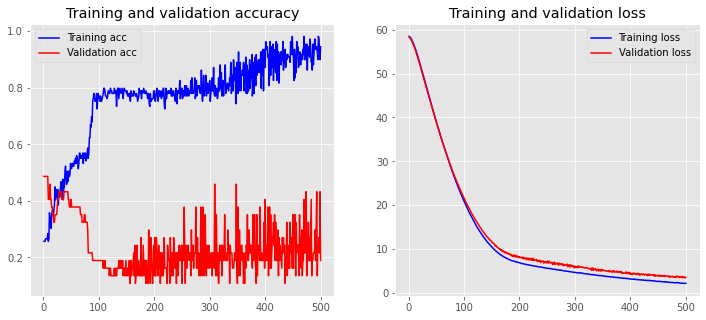

In [48]:
es=EarlyStopping(monitor='val_loss',patience=30, restore_best_weights=True)

history = mod.fit(X_train, y_train,
                    epochs=500,
                    validation_data=(X_test, y_test),
                    batch_size=256, callbacks=[es])
loss, accuracy = mod.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = mod.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [112]:
comentario = ['"El presidente en alocución oficial pronunció un discurso de odio y terror para toda la población, incitando al linchamiento de todo aquel de la oposición y declarando que la única postura válida en el país era la ultraderecha."']

In [113]:
comentario = t.texts_to_sequences(comentario)


In [114]:
comentario = pad_sequences(comentario, padding = 'pre',maxlen=news_num)


In [115]:
np.argmax(mod.predict(comentario), axis=-1)

array([1])